<a href="https://colab.research.google.com/github/apester/PINN/blob/main/PINN_1D_AdvectionDiffusion_Periodic_SineIC_CN_Exact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Advection–Diffusion on (0,L): **Crank–Nicolson (periodic) + Symbolic Solution + PINN**

We solve the constant-coefficient advection–diffusion equation:
\[
c_t + u\,c_x = D\,c_{xx},\qquad x\in(0,L),\ t\ge 0
\]
with initial condition
\[
c(x,0) = \sin\!\left(\frac{2\pi}{L}x\right).
\]

## Boundary condition choice
A single sinusoidal mode is naturally compatible with **periodic BC**:
\(
c(0,t)=c(L,t),\ c_x(0,t)=c_x(L,t).
\)
Under periodic BC, there is a clean closed-form solution.

## What we do
1) Exact (symbolic) solution (periodic).  
2) Crank–Nicolson diffusion + explicit upwind advection (IMEX), periodic.  
3) PINN enforcing PDE + IC + periodic BC (value + derivative).  
4) Compare errors and visualize results.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [2]:

# Parameters
L = 2.0
u = 1.0
D = 0.5

N = 400
dx = L / N
T = 1.0
dt = 1e-3
Nt = int(np.round(T/dt))

k = 2*np.pi / L

print('dx=', dx, 'Nt=', Nt, 'CFL=', abs(u)*dt/dx, 'mu=', D*dt/dx**2)
assert abs(u)*dt/dx <= 1.0 + 1e-12, 'Upwind CFL violated: reduce dt.'


dx= 0.005 Nt= 1000 CFL= 0.2 mu= 20.0


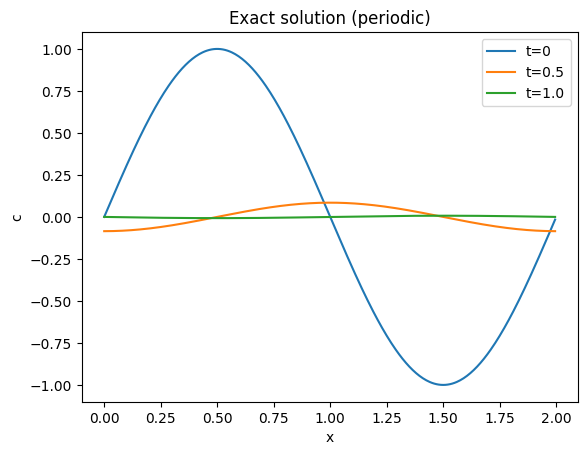

In [3]:

# Exact periodic solution
def c_exact(x, t):
    return np.exp(-D*(k**2)*t) * np.sin(k*(x - u*t))

xg = np.linspace(0, L, N, endpoint=False)
plt.figure()
plt.plot(xg, c_exact(xg, 0.0), label='t=0')
plt.plot(xg, c_exact(xg, 0.5), label='t=0.5')
plt.plot(xg, c_exact(xg, 1.0), label='t=1.0')
plt.title('Exact solution (periodic)')
plt.xlabel('x'); plt.ylabel('c')
plt.legend(); plt.show()


In [4]:

# Tridiagonal solver
def thomas_solve(a, b, c, d):
    n = len(b)
    cp = np.zeros(n-1)
    dp = np.zeros(n)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    for i in range(1, n-1):
        denom = b[i] - a[i-1]*cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1]*dp[i-1]) / denom
    denom = b[n-1] - a[n-2]*cp[n-2]
    dp[n-1] = (d[n-1] - a[n-2]*dp[n-2]) / denom
    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i]*x[i+1]
    return x

# Cyclic tridiagonal via Sherman–Morrison
def solve_cyclic_tridiagonal(a, b, c, alpha, beta, d):
    n = len(b)
    bb = b.copy()
    gamma = -b[0]  # arbitrary nonzero
    bb[0] = b[0] - gamma
    bb[-1] = b[-1] - alpha*beta/gamma

    y = thomas_solve(a, bb, c, d)

    uvec = np.zeros(n)
    uvec[0] = gamma
    uvec[-1] = beta
    z = thomas_solve(a, bb, c, uvec)

    fact = (y[0] + alpha*y[-1]/gamma) / (1.0 + z[0] + alpha*z[-1]/gamma)
    return y - fact*z


Numerical solution shape: (1001, 400)


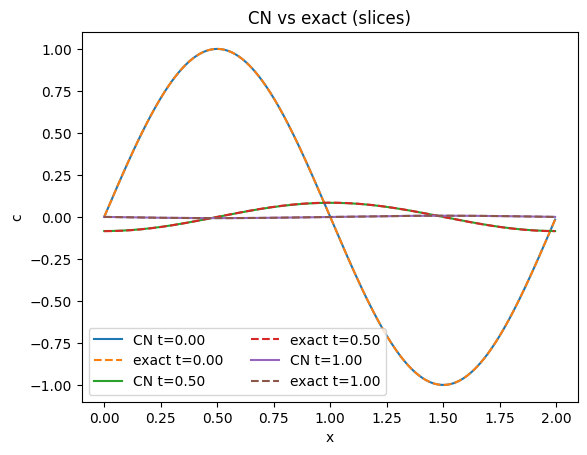

In [5]:

# IMEX: upwind advection (explicit) + diffusion CN (implicit), periodic
def solve_imex_cn_upwind_periodic():
    x = np.linspace(0, L, N, endpoint=False)
    t = np.linspace(0, Nt*dt, Nt+1)
    C = np.zeros((Nt+1, N), dtype=float)

    C[0] = np.sin(k*x)

    lam = u*dt/dx
    mu = D*dt/dx**2

    a = (-mu/2.0) * np.ones(N-1)
    b = (1.0 + mu) * np.ones(N)
    c = (-mu/2.0) * np.ones(N-1)
    alpha = -mu/2.0
    beta  = -mu/2.0

    for n in range(Nt):
        cn = C[n]

        if u >= 0:
            adv = lam * (cn - np.roll(cn, 1))
        else:
            adv = lam * (np.roll(cn, -1) - cn)

        # RHS = cn + (mu/2) L cn - adv
        rhs = cn + (mu/2.0) * (np.roll(cn, -1) - 2*cn + np.roll(cn, 1)) - adv

        C[n+1] = solve_cyclic_tridiagonal(a, b, c, alpha, beta, rhs)

    return x, t, C

x_num, t_num, C_num = solve_imex_cn_upwind_periodic()
print('Numerical solution shape:', C_num.shape)

plt.figure()
for tt in [0.0, 0.5, 1.0]:
    idx = int(round(tt/dt))
    plt.plot(x_num, C_num[idx], label=f'CN t={t_num[idx]:.2f}')
    plt.plot(x_num, c_exact(x_num, t_num[idx]), '--', label=f'exact t={t_num[idx]:.2f}')
plt.xlabel('x'); plt.ylabel('c'); plt.title('CN vs exact (slices)')
plt.legend(ncol=2); plt.show()


In [6]:

# Error metrics
def rel_l2(pred, gt):
    return np.linalg.norm((pred-gt).ravel()) / (np.linalg.norm(gt.ravel()) + 1e-12)

def mae(pred, gt):
    return np.mean(np.abs(pred-gt))

times_eval = [0.25, 0.5, 0.75, 1.0]
print('CN vs exact errors:')
for tt in times_eval:
    idx = int(round(tt/dt))
    gt = c_exact(x_num, t_num[idx])
    pred = C_num[idx]
    print(f'  t={t_num[idx]:.2f}: relL2={rel_l2(pred,gt):.3e}, MAE={mae(pred,gt):.3e}')


CN vs exact errors:
  t=0.25: relL2=5.272e-03, MAE=9.774e-04
  t=0.50: relL2=1.052e-02, MAE=5.679e-04
  t=0.75: relL2=1.574e-02, MAE=2.474e-04
  t=1.00: relL2=2.093e-02, MAE=9.584e-05


## PINN enforcing PDE + IC + periodic BC (value and derivative)

In [7]:

class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=128, depth=6):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)

pinn = MLP().to(device)
pinn


MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [8]:

def pde_residual_pinn(net, X):
    X = X.clone().requires_grad_(True)  # [x,t]
    c = net(X)
    grads = torch.autograd.grad(c, X, torch.ones_like(c), create_graph=True, retain_graph=True)[0]
    c_x = grads[:,0:1]
    c_t = grads[:,1:2]
    c_xx = torch.autograd.grad(c_x, X, torch.ones_like(c_x), create_graph=True, retain_graph=True)[0][:,0:1]
    return c_t + u*c_x - D*c_xx

def c_x(net, X):
    X = X.clone().requires_grad_(True)
    c = net(X)
    grads = torch.autograd.grad(c, X, torch.ones_like(c), create_graph=True, retain_graph=True)[0]
    return grads[:,0:1]


In [9]:

# Sample training points
def to_torch(a):
    return torch.tensor(a, dtype=torch.float32, device=device).view(-1,1)

n_f = 30000
n_ic = 4000
n_bc = 4000

x_f = np.random.rand(n_f) * L
t_f = np.random.rand(n_f) * T
X_f = torch.cat([to_torch(x_f), to_torch(t_f)], dim=1)

x_ic = np.random.rand(n_ic) * L
t_ic = np.zeros(n_ic)
c_ic = np.sin(k*x_ic)
X_ic = torch.cat([to_torch(x_ic), to_torch(t_ic)], dim=1)
Y_ic = to_torch(c_ic)

t_bc = np.random.rand(n_bc) * T
X_b0 = torch.cat([to_torch(np.zeros(n_bc)), to_torch(t_bc)], dim=1)
X_bL = torch.cat([to_torch(np.ones(n_bc)*L), to_torch(t_bc)], dim=1)

print(X_f.shape, X_ic.shape, X_b0.shape, X_bL.shape)


torch.Size([30000, 2]) torch.Size([4000, 2]) torch.Size([4000, 2]) torch.Size([4000, 2])


In [10]:

# Train PINN
w_f = 1.0
w_ic = 20.0
w_bc_val = 5.0
w_bc_der = 1.0

opt = torch.optim.Adam(pinn.parameters(), lr=1e-3)
loss_hist = []

epochs = 6000
print_every = 300

for ep in range(1, epochs+1):
    opt.zero_grad()

    loss_ic = ((pinn(X_ic) - Y_ic)**2).mean()
    loss_bv = ((pinn(X_b0) - pinn(X_bL))**2).mean()
    loss_bd = ((c_x(pinn, X_b0) - c_x(pinn, X_bL))**2).mean()

    r = pde_residual_pinn(pinn, X_f)
    loss_f = (r**2).mean()

    loss = w_f*loss_f + w_ic*loss_ic + w_bc_val*loss_bv + w_bc_der*loss_bd
    loss.backward()
    opt.step()

    loss_hist.append([loss.item(), loss_f.item(), loss_ic.item(), loss_bv.item(), loss_bd.item()])

    if ep % print_every == 0 or ep == 1:
        print(f'Epoch {ep:5d} | total {loss.item():.3e} | f {loss_f.item():.3e} | ic {loss_ic.item():.3e} | bcV {loss_bv.item():.3e} | bcD {loss_bd.item():.3e}')


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:865: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:330.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch     1 | total 9.459e+00 | f 1.042e-03 | ic 4.682e-01 | bcV 1.850e-02 | bcD 2.311e-03
Epoch   300 | total 5.881e-02 | f 2.513e-02 | ic 1.042e-03 | bcV 1.836e-03 | bcD 3.650e-03
Epoch   600 | total 9.662e-03 | f 6.146e-03 | ic 8.555e-05 | bcV 2.053e-04 | bcD 7.781e-04
Epoch   900 | total 9.089e-03 | f 2.549e-03 | ic 1.809e-04 | bcV 5.004e-04 | bcD 4.200e-04
Epoch  1200 | total 1.083e-02 | f 1.432e-03 | ic 2.735e-04 | bcV 6.930e-04 | bcD 4.647e-04
Epoch  1500 | total 1.585e-03 | f 8.936e-04 | ic 1.577e-05 | bcV 4.191e-05 | bcD 1.667e-04
Epoch  1800 | total 4.001e-03 | f 7.018e-04 | ic 1.334e-04 | bcV 4.740e-05 | bcD 3.943e-04
Epoch  2100 | total 8.024e-03 | f 7.690e-04 | ic 2.414e-04 | bcV 4.108e-04 | bcD 3.735e-04
Epoch  2400 | total 4.380e-03 | f 5.795e-04 | ic 1.018e-04 | bcV 3.230e-04 | bcD 1.492e-04
Epoch  2700 | total 1.216e-02 | f 6.127e-04 | ic 3.503e-04 | bcV 8.307e-04 | bcD 3.876e-04
Epoch  3000 | total 2.001e-02 | f 7.906e-04 | ic 6.711e-04 | bcV 9.960e-04 | bcD 8.153e-04

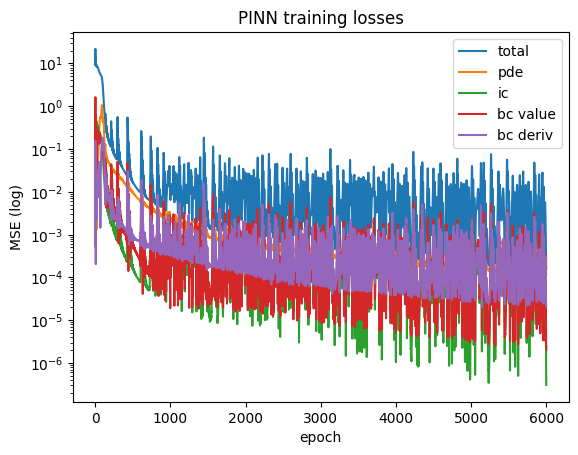

PINN vs exact errors:
  t=0.25: relL2=1.602e-03, MAE=2.783e-04
  t=0.50: relL2=1.329e-02, MAE=6.191e-04
  t=0.75: relL2=5.905e-02, MAE=7.474e-04
  t=1.00: relL2=1.653e-01, MAE=5.690e-04
PINN vs CN errors:
  t=0.25: relL2=6.568e-03, MAE=1.236e-03
  t=0.50: relL2=1.430e-02, MAE=7.773e-04
  t=0.75: relL2=7.395e-02, MAE=9.936e-04
  t=1.00: relL2=1.731e-01, MAE=6.211e-04


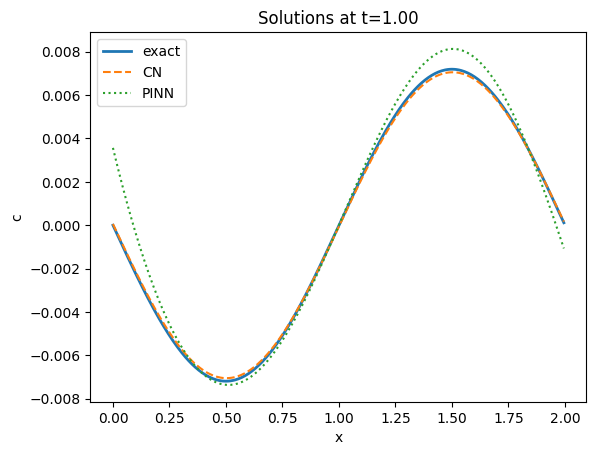

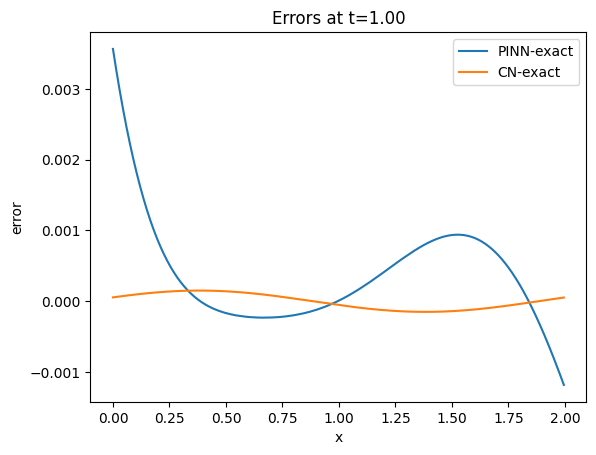

In [11]:

# Evaluate PINN vs exact and vs CN + plots
loss_hist = np.array(loss_hist)
plt.figure()
plt.semilogy(loss_hist[:,0], label='total')
plt.semilogy(loss_hist[:,1], label='pde')
plt.semilogy(loss_hist[:,2], label='ic')
plt.semilogy(loss_hist[:,3], label='bc value')
plt.semilogy(loss_hist[:,4], label='bc deriv')
plt.xlabel('epoch'); plt.ylabel('MSE (log)')
plt.title('PINN training losses')
plt.legend(); plt.show()

@torch.no_grad()
def pinn_predict(x, t):
    X = torch.tensor(np.column_stack([x, t]), dtype=torch.float32, device=device)
    return pinn(X).cpu().numpy().ravel()

print('PINN vs exact errors:')
for tt in times_eval:
    idx = int(round(tt/dt))
    gt = c_exact(x_num, t_num[idx])
    pred = pinn_predict(x_num, np.full_like(x_num, t_num[idx]))
    print(f'  t={t_num[idx]:.2f}: relL2={rel_l2(pred,gt):.3e}, MAE={mae(pred,gt):.3e}')

print('PINN vs CN errors:')
for tt in times_eval:
    idx = int(round(tt/dt))
    gt = C_num[idx]
    pred = pinn_predict(x_num, np.full_like(x_num, t_num[idx]))
    print(f'  t={t_num[idx]:.2f}: relL2={rel_l2(pred,gt):.3e}, MAE={mae(pred,gt):.3e}')

# Visual at final time
idx = int(round(1.0/dt))
gt = c_exact(x_num, t_num[idx])
cn = C_num[idx]
pn = pinn_predict(x_num, np.full_like(x_num, t_num[idx]))

plt.figure()
plt.plot(x_num, gt, label='exact', linewidth=2)
plt.plot(x_num, cn, '--', label='CN')
plt.plot(x_num, pn, ':', label='PINN')
plt.xlabel('x'); plt.ylabel('c'); plt.title(f'Solutions at t={t_num[idx]:.2f}')
plt.legend(); plt.show()

plt.figure()
plt.plot(x_num, pn-gt, label='PINN-exact')
plt.plot(x_num, cn-gt, label='CN-exact')
plt.xlabel('x'); plt.ylabel('error'); plt.title(f'Errors at t={t_num[idx]:.2f}')
plt.legend(); plt.show()
